## Pokemon classification model

### Imports

In [ ]:
# first, we'll import tools/modules we need for our pytorch models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, Dataset # easy way to deal with data

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm # nice looking progress bars
import time

from google.colab import drive
import os


from PIL import Image

In [ ]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Extract data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
os.listdir(os.path.join('drive', 'MyDrive', 'Pokedex'))

['Pokedex.v7i.folder.zip', 'models', 'Pokedex.v9i.folder.zip']

In [ ]:
data_path = os.path.join('drive', 'MyDrive', 'Pokedex')

The dataset can be found at https://universe.roboflow.com/test-kc3qp/pokedex-fexzz and was annotated + augmented using roboflow

In [ ]:
import zipfile

# Path to the zip file and where to extract
zip_path = os.path.join(data_path, 'Pokedex.v9i.folder.zip')
extract_to = os.path.join(data_path, 'pokedex')

# Check if it already exists
if not os.path.exists(extract_to):
  # Extract the zip file
  print(f'Extracting {zip_path} to {extract_to}')
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to)
else:
  print(f'Archive already extracted to {extract_to}')

Extracting drive/MyDrive/Pokedex/Pokedex.v9i.folder.zip to drive/MyDrive/Pokedex/pokedex


In [ ]:
os.listdir(data_path)

['Pokedex.v7i.folder.zip', 'models', 'Pokedex.v9i.folder.zip', 'pokedex']

In [ ]:
poke_data_path = os.path.join(data_path, 'pokedex')

In [ ]:
print(os.listdir(os.path.join(poke_data_path, 'train')))
print(len(os.listdir(os.path.join(poke_data_path, 'train'))))
print(os.listdir(os.path.join(poke_data_path, 'test')))
print(len(os.listdir(os.path.join(poke_data_path, 'test'))))

['bulbosaur', 'charmander', 'gengar', 'magikarp', 'mew', 'pikachu', 'psyduck', 'squirtle']
8
['bulbosaur', 'charmander', 'gengar', 'magikarp', 'mew', 'pikachu', 'psyduck', 'squirtle']
8


Load data into a torch dataset. Classes are split by folders.

Current data folder structure

```
pokedex
  - train
    - bulbosaur
    - charmander
    - gengar
    - magikarp
    - mew
    - pikachu
    - psyduck
    - squirtle
  - test
    - ...
  - valid
    - ...


In [ ]:
class PokeDataset(Dataset):

  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.samples =[]

    # Get sorted lsit of class folder names
    self.classes = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])

    # Map class names to integer labels
    self.class_to_labels = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    # Collect all images paths and labels
    for cls_name in self.classes:
      cls_dir = os.path.join(root_dir, cls_name)
      for fname in os.listdir(cls_dir):
        fpath = os.path.join(cls_dir, fname)
        if os.path.isfile(fpath) and fname.lower().endswith(('.jpg', 'jprg', 'png')):
          self.samples.append((fpath, self.class_to_labels[cls_name]))

  # override length
  def __len__(self):
    return len(self.samples)

  # overide get item
  def __getitem__(self, idx):
    image_path, label = self.samples[idx]
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, label

In [ ]:
# composite the transforms include data augmentation
train_transform = transforms.Compose([
    transforms.Resize(200),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(200),
    transforms.ToTensor()
])

In [ ]:
trainset = PokeDataset(os.path.join(poke_data_path, 'train'), transform=train_transform)
valset = PokeDataset(os.path.join(poke_data_path, 'valid'), transform=val_transform)

8 classes of images that are 200 x 200 with 3 channels (R,G,B)

In [ ]:
loader = DataLoader(trainset, batch_size = 8, shuffle=True)

images, labels = next(iter(loader))

print(images.shape, labels.shape)

torch.Size([8, 3, 200, 200]) torch.Size([8])


Calculate mean and std for normalization

In [ ]:
mean = 0.
std = 0.
n_samples = 0.

for images, _ in loader:
    # images shape: (B, C, H, W)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)

    mean += images.mean(2).sum(0)  # sum over batches
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.5191, 0.4885, 0.4491])
Std: tensor([0.2227, 0.2106, 0.1982])


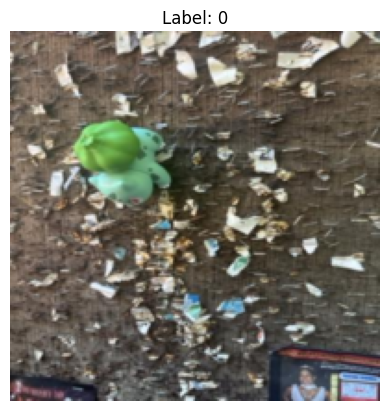

In [ ]:
# get first image
img = images[0]


# show image
plt.imshow(img.permute(1,2,0))
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4960, 0.4695, 0.4262], std=[0.2158, 0.2027, 0.1885])
])
trainset = PokeDataset(os.path.join(poke_data_path, 'train'), transform=transform)
valset = PokeDataset(os.path.join(poke_data_path, 'valid'), transform=transform)
testset = PokeDataset(os.path.join(poke_data_path, 'test'), transform=transform)

In [ ]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, )
valloader = DataLoader(valset, batch_size=32, shuffle=False, )
testloader = DataLoader(testset, batch_size=32, shuffle=False,)

### Model architecture

In [ ]:

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.batchNorm1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.batchNorm2 = nn.BatchNorm2d(32)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.batchNorm3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.batchNorm4 = nn.BatchNorm2d(128)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(18432, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 8)
  def forward(self, x):
    x = torch.relu(self.batchNorm1(self.conv1(x)))

    x = self.pool1(x)

    x = torch.relu(self.batchNorm2(self.conv2(x)))
    x = self.pool2(x)

    x = torch.relu(self.batchNorm3(self.conv3(x)))
    x = self.pool3(x)

    x = torch.relu(self.batchNorm4(self.conv4(x)))
    x = self.pool4(x)


    x = x.view(-1, 18432)

    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name ="Model"):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  model.train()

  print(f'--- Training {model_name} for {num_epochs} epochs ---')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    acc_val = 0
    total_val = 0
    running_val_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for data, target in pbar:
      data, target = data.to(device), target.to(device)

      # Step 1: zero the gradient
      optimizer.zero_grad()

      # Step 2: forward pass
      output = model(data)

      # Step 3: Calculate the loss
      loss = criterion(output, target)

      # Step 4: Backward pass
      loss.backward()

      # Step 5: Update the weifhts
      optimizer.step()

      running_loss+= loss.item()
      _, predicted = torch.max(output.data, 1)
      total +=target.size(0)
      correct += (predicted == target).sum().item()

      pbar.set_postfix({'Loss': f'{running_loss/len(train_loader)}', 'Accuracy': f'{100*correct/total}'})

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    with torch.no_grad():
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss = criterion(output, target)
        running_val_loss += val_loss.item()

        _, predicted = torch.max(output.data, 1)
        total_val += target.size(0)
        acc_val += (predicted == target).sum().item()
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = 100 * acc_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy {val_accuracy}")

  print(f'---Finished training {model_name}---')
  return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def evaulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data) # Forward pass
      _, predicted = torch.max(output, 1)
      total+= target.size(0)
      correct += (predicted == target).sum().item()

  return 100 * correct / total


In [ ]:
from torchvision.models import vgg11_bn, VGG11_BN_Weights

In [ ]:
test_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:04<00:00, 107MB/s] 


In [ ]:
class Net(nn.Module):
  def __init__(self, num_classes=100):
    super(Net, self).__init__()
    self.base_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

    # Freeze featurizer
    for param in self.base_model.parameters():
      param.requires_grad = False

    # Replace the classifier
    self.base_model.classifier = nn.Sequential(
        nn.Linear(25088, 1280, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(.3),
        nn.Linear(1280,8, bias=True)
    )

    for params in self.base_model.classifier.parameters():
      params.requires_grad = True

  def forward(self,x):
    outputs = self.base_model(x)
    return outputs

### Train model

In [ ]:
model_cnn = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()
print(model_cnn)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, st

In [ ]:
cnn_losses, cnn_accuracies, val_losses, val_accuracies = train_model(model_cnn, trainloader, valloader,criterion, optimizer_cnn, num_epochs=2, model_name="CNN on PokeDex")

--- Training CNN on PokeDex for 2 epochs ---


Epoch 1/2: 100%|██████████| 150/150 [05:25<00:00,  2.17s/it, Loss=1.8887593754132588, Accuracy=40.754638315613924]


Validation Accuracy 64.01028277634961


Epoch 2/2: 100%|██████████| 150/150 [05:02<00:00,  2.02s/it, Loss=0.9253184199333191, Accuracy=66.49989576818845]


Validation Accuracy 77.12082262210797
---Finished training CNN on PokeDex---
Accuracy of the CNN on Pokedex: 78.57%


### Evaluation

Custom CNN model accuracy: ~90%
VGGNet11 accuracy: >93%

In [ ]:
cnn_accuracy = evaulate_model(model_cnn, testloader)
print(f'Accuracy of the CNN on Pokedex: {cnn_accuracy:.2f}%')

Accuracy of the CNN on Pokedex: 78.57%


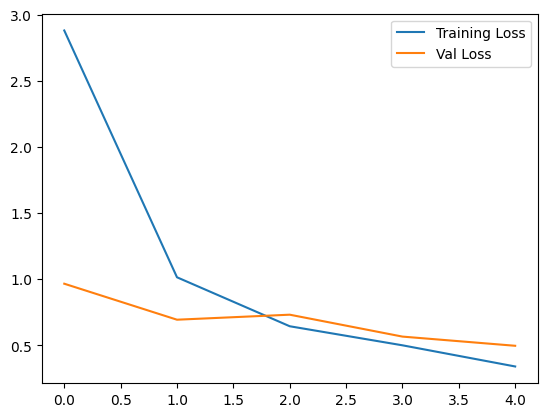

In [ ]:
plt.plot(cnn_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

In [ ]:
save_to = os.path.join('drive', 'MyDrive', 'Pokedex', 'models', "poke_model_vgg_v2.pth")

# save weights
torch.save(model_cnn.state_dict(), save_to)

In [ ]:
class Denormalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean

In [ ]:
dataiter = iter(testloader)

Display images with their true label and the model predicted model

2


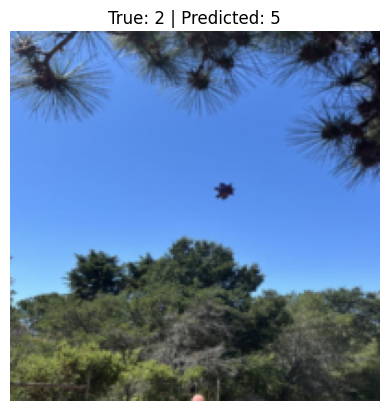

2


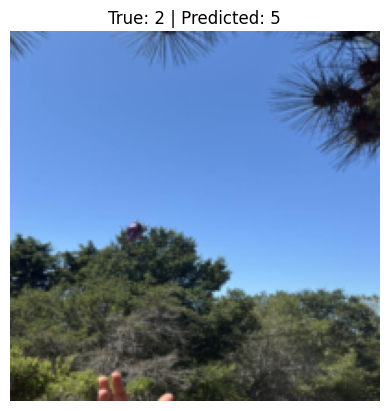

2


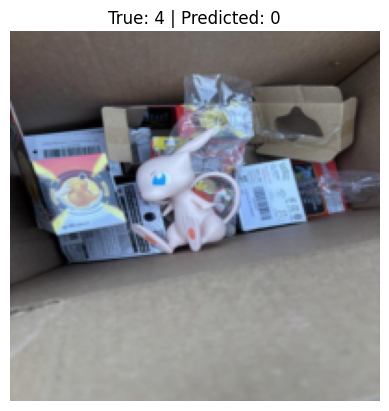

2


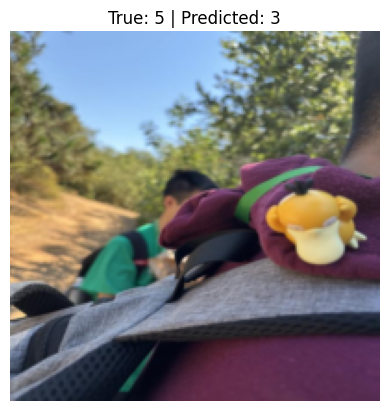

32
tensor([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
        5, 5, 5, 5, 5, 5, 5, 5])
tensor([2, 2, 2, 2, 2, 5, 5, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 5,
        5, 5, 5, 5, 5, 3, 5, 5])


In [ ]:

images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

denorm = Denormalize(mean=[0.4960, 0.4695, 0.4262], std=[0.2158, 0.2027, 0.1885])

# Forward pass
with torch.no_grad():
    outputs = model_cnn(images)
    _, predicted = torch.max(outputs, 1)

# Display image
def imshow(img, idx):
    img = denorm(img).cpu()  # move to CPU for plotting
    img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    plt.imshow(img)
    plt.axis('off')
    print(labels[0].item())
    plt.title(f"True: {labels[idx].item()} | Predicted: {predicted[idx].item()}")
    plt.show()
for i in range(len(images)):
  if labels[i].item()!=predicted[i].item():
    imshow(images[i], i)
# imshow(images[10], 10)
print(len(labels))
print(labels)
print(predicted)
